In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn; seaborn.set()

import warnings
warnings.filterwarnings('ignore')

In [2]:
from cesium import datasets

eeg = datasets.fetch_andrzejak()

Loaded data from cached archive.


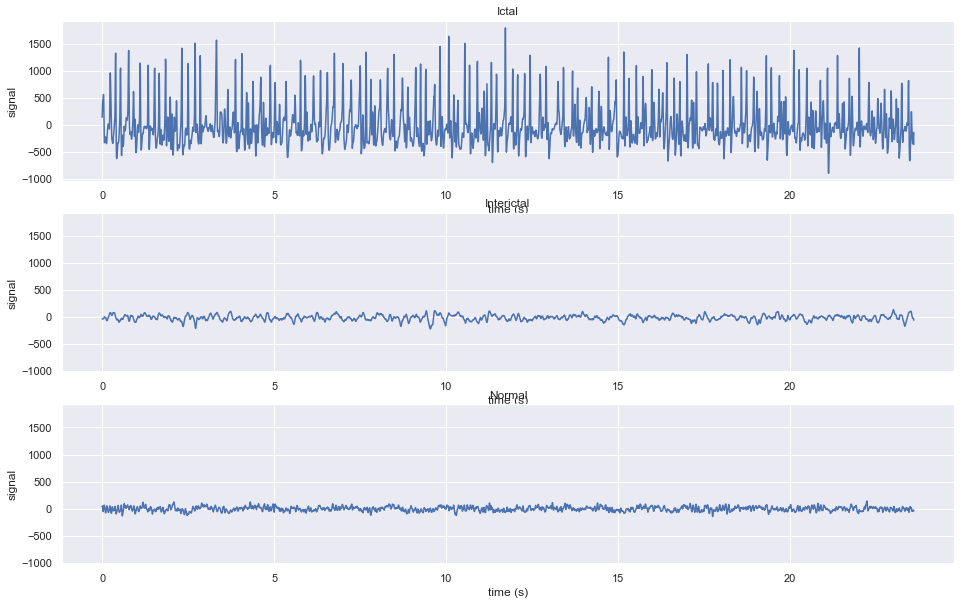

In [3]:
# Group together classes (Z, O), (N, F), (S) as normal, interictal, ictal
eeg["classes"] = eeg["classes"].astype("U16") #  allocate memory for longer class names
eeg["classes"][np.logical_or(eeg["classes"]=="Z", eeg["classes"]=="O")] = "Normal"
eeg["classes"][np.logical_or(eeg["classes"]=="N", eeg["classes"]=="F")] = "Interictal"
eeg["classes"][eeg["classes"]=="S"] = "Ictal"

fig, ax = plt.subplots(len(np.unique(eeg["classes"])), 1, sharey=True, figsize=(16,10))
for label, subplot in zip(np.unique(eeg["classes"]), ax):
    i = np.where(eeg["classes"] == label)[0][0]
    subplot.plot(eeg["times"][i], eeg["measurements"][i])
    subplot.set(xlabel="time (s)", ylabel="signal", title=label)

# Generate artificial noise

In [4]:
from scipy.signal import chirp,sawtooth

# Featurization functions

In [5]:
import numpy as np
import scipy.stats
from cesium import featurize
import pywt

def mean_signal(t, m, e):
    return np.mean(m)

def std_signal(t, m, e):
    return np.std(m)

def mean_square_signal(t, m, e):
    return np.mean(m ** 2)

def abs_diffs_signal(t, m, e):
    return np.sum(np.abs(np.diff(m)))

def skew_signal(t, m, e):
    return scipy.stats.skew(m)


guo_features = {
    "mean": mean_signal,
    "std": std_signal,
    "mean2": mean_square_signal,
    "abs_diffs": abs_diffs_signal,
    "skew": skew_signal
}

In [6]:
amp_results = []
freq_results = []

def generateNoise(freq,amp):
    amp_results.append(amp)
    freq_results.append(freq)
    
    # Add noise
    mu, sigma = 0, 3.3 # mean and standard deviation
    x = len(eeg["times"][0])
    
    eeg["noisy_measurements"] = eeg["measurements"].copy()

    for i in range(0, 500):
        eeg["noisy_measurements"][i] = eeg["measurements"][i] + \
        amp * np.random.normal(mu, sigma, x) + \
        amp * chirp(eeg["times"][i], f0=freq, f1=1, t1=10, method='linear') + \
        amp * sawtooth(2 * np.pi * freq * eeg["times"][i])
        

In [7]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


train_results = []
test_results = []

def runGuoClassifier():
    # Featurize
    # guo
    n_channels = 5
    eeg["dwts"] = [pywt.wavedec(m, pywt.Wavelet("db1"), level=n_channels-1)
                   for m in eeg["noisy_measurements"]]
    fset_dwt = featurize.featurize_time_series(times=None, values=eeg["dwts"], errors=None,
                                           features_to_use=list(guo_features.keys()),
                                           custom_functions=guo_features)
    
    # Model building
    train, test = train_test_split(np.arange(len(eeg["classes"])), random_state=17)

    model_dwt = KNeighborsClassifier(3)
    model_dwt.fit(fset_dwt.iloc[train], eeg["classes"][train])

    
    # Prediction
    preds_dwt = model_dwt.predict(fset_dwt)
    
    train_r = accuracy_score(preds_dwt[train], eeg["classes"][train])
    test_r = accuracy_score(preds_dwt[test], eeg["classes"][test])
    
    train_results.append(train_r)
    test_results.append(test_r)
    
    print("Wavelet transform features: training accuracy={:.2%}, test accuracy={:.2%}".format(
          train_r, test_r))

# Loop

In [ ]:
print("With no noise")
generateNoise(0,0)
runGuoClassifier();

noises_amp = [10, 50]
noises_freq = [5, 30]

for amp in noises_amp:
    for freq in noises_freq:
        print("With noise amp:", amp, " noise freq:", freq)
        generateNoise(freq,amp)
        runGuoClassifier();

With no noise
Wavelet transform features: training accuracy=97.33%, test accuracy=96.00%
With noise amp: 10  noise freq: 5
Wavelet transform features: training accuracy=96.80%, test accuracy=92.80%
With noise amp: 10  noise freq: 30
Wavelet transform features: training accuracy=96.53%, test accuracy=94.40%
With noise amp: 50  noise freq: 5
Wavelet transform features: training accuracy=87.20%, test accuracy=81.60%
With noise amp: 50  noise freq: 30


In [ ]:
amp_length = len(noises_amp)
freq_length = len(noises_freq)

graph_x = []
graph_y = []

# init array
for i in range(freq_length):
    graph_x.append([])
    graph_y.append([])

# prepare
for j in range(amp_length):
    for i in range(freq_length):
        graph_x[i].append(noises_amp[j])
        index = (j*freq_length)+1+i
        graph_y[i].append(test_results[index])

# plot
plt.ylim(0.75, 1)

for i in range(freq_length):
    label = str(noises_freq[i]) + " hz"
    plt.plot(graph_x[i], graph_y[i], label = label)


# naming the x axis 
plt.xlabel('amp') 
# naming the y axis 
plt.ylabel('test accuracy') 
# giving a title to my graph 
plt.title('result') 
  
# show a legend on the plot 
plt.legend() 
  
# function to show the plot 
plt.show() 